<a href="https://colab.research.google.com/github/Tecnologico-de-Monterrey-MNA/nlp-2023-Equipo-5/blob/main/Equipo05_semana09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

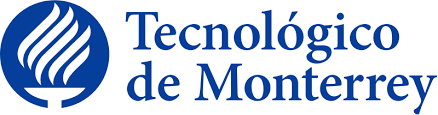

#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Procesamiento de Lenguaje Natural (NLP)**
###Tecnológico de Monterrey
###Prof Luis Eduardo Falcón Morales

## **Actividad en Equipos - Semana 9: Traducciones y clasificación de textos**

###**Equipo 5:**

###**A01748750 - Evelyn Aylin Rendón Medina**
###**A01002111 - Luis Salvador Cruz Najera**
###**A01169213 - Laura Elena Hernández Mata**
###**A01793052 - Juan Carlos Lopez Cruz**
###**A01793054 - Rafael José Mateo Comprés**


#**Actividad en Equipos - Semana 5:**

En la actividad de esta semana trabajarás en equipos mediante el uso de Transformers.

HuggingFace (HF) es una plataforma de una comunidad de IA que promueve las contribuciones de código
abierto, en particular para compartir modelos de aprendizaje profundo, entre ellos los Transformers o modelos basados en el mecanismo de Attention: https://huggingface.co/

La plataforma de HF está muy bien documentada, es de acceso abierto, pero deberás generar una cuenta sin costo para su uso. En ocasiones deberás generar una clave para el uso de algunos modelos, pero es solo para el control del uso de dicha plataforma y no generan algún costo para su uso educativo o de investigación, al menos hasta ahora.

En particular en esta actividad estarás usando varios de los modelos Transformer que hacen tareas diversas, tanto en inglés como en español. El objetivo es que te familiarices con dicha plataforma y experimentes posteriormente con ella para las tareas o problemáticas particulares que te interesen.

### **Librerías que se deben Instalar.**

In [ ]:
!pip install transformers==4.28.0 datasets evaluate pysentimiento sentencepiece sacremoses accelerate
!apt-get install git-lfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


# **Actividades:**

##1.- Descarga el archivo amazonbaby5000.csv que se encuentra en Canvas. Este archivo está formado de comentarios en inglés sobre productos para bebé adquiridos en la plataforma de Amazon.###

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import evaluate
from evaluate import evaluator
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer, pipeline
from transformers import AutoConfig
from datasets import Dataset, load_dataset, DatasetDict, load_metric
from accelerate import Accelerator
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch


### Lectura de Datos en un Data Set

In [ ]:
ds = load_dataset("csv", data_files='https://raw.githubusercontent.com/luiscruzn/data/main/amazonbaby5000.csv')
ds = ds.rename_column('rating', 'labels')

ds

  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['review', 'labels'],
        num_rows: 5000
    })
})

In [ ]:
#Hacemos una copia de los datos originales, ya que los necesitaremos en el ejercicio 4
ds_copy = ds.copy()

Definimos algunas funciones que estaremos utilizando más adelante.

In [ ]:
def split_dataset(ds):
    #Hacemos partición de entrenamiento, validación y prueba
    ds = ds.class_encode_column ('labels')

    train_test_valid = ds['train'].train_test_split(test_size=0.3, seed=42, stratify_by_column='labels')

    # Particionamos validación y prueba en dos grupos (c/u con 50%)
    test_valid = train_test_valid['test'].train_test_split(test_size=0.5, seed = 42, stratify_by_column='labels')

    #Ahora hacemos un solo dataset con las tres particiones
    return DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

In [ ]:
def get_device():
    if torch.backends.mps.is_available():
        return torch.device('mps')
    elif torch.cuda.is_available():
        return torch.device(torch.cuda.current_device())
    else:
        return torch.device('cpu')

In [ ]:
def get_model(model_name: str, num_labels = None, max_length = 512):

    if num_labels == None:
        num_labels = AutoConfig.from_pretrained(model_name).num_labels

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = num_labels, max_length = max_length)
    tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=max_length)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    model.to(get_device())

    return (model, tokenizer, data_collator)

In [ ]:
def evaluate_results(pipe, data, label_mapping: dict = None):

    task_evaluator = evaluator("sentiment-analysis")
    return task_evaluator.compute(
    model_or_pipeline = pipe,
    input_column = 'review',
    label_mapping= label_mapping,
    label_column = 'labels',
    data = data)

In [ ]:
def preprocess_function(examples):
   tensor = tokenizer(examples['review'], truncation=True, padding = True, return_tensors="pt")
   tensor.to(device)

   return tensor

In [ ]:
def compute_metrics(eval_pred):
   load_accuracy = evaluate.load("accuracy")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]

   return {"accuracy": accuracy}

In [ ]:
def get_training_args():

    return TrainingArguments(
    output_dir=f'./results',
    learning_rate=2e-5,
    do_eval=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    save_strategy="epoch",
    use_mps_device=torch.backends.mps.is_available())

## 2.- Realiza una partición de los datos en el porcentaje que consideres adecuado, entrenamiento, validación y prueba.###

### Partición de datos para entrenamiento, validación y prueba

In [ ]:
ds = split_dataset(ds)
ds

DatasetDict({
    train: Dataset({
        features: ['review', 'labels'],
        num_rows: 3500
    })
    test: Dataset({
        features: ['review', 'labels'],
        num_rows: 750
    })
    valid: Dataset({
        features: ['review', 'labels'],
        num_rows: 750
    })
})

### Visualización de partición de datos

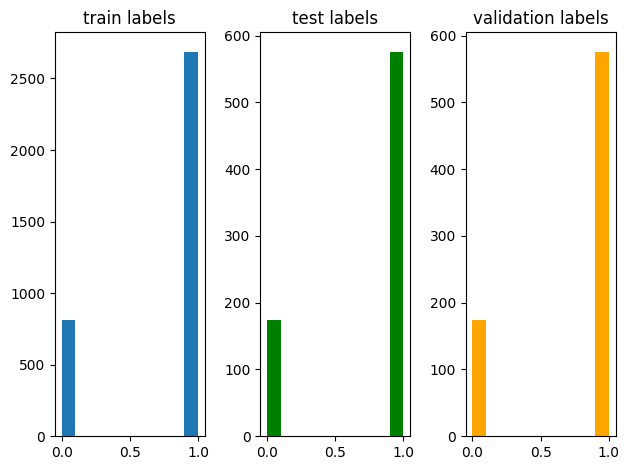

In [ ]:
from matplotlib import pyplot as plt
fig,(ax1, ax2, ax3) = plt.subplots(1,3)
ax1.set_title('train labels')
ax1.hist(ds['train']['labels'])
ax2.set_title('test labels')
ax2.hist(ds['test']['labels'],color='green')
ax3.set_title('validation labels')
ax3.hist(ds['valid']['labels'],color='orange')
fig.tight_layout()

**Nota:**
Se observa que los datos al particionarlos conservaron la misma proporción de datos pero es claro que esta base de datos amazonbaby5000 esta desbalanceada ya que tiene más etiquetas positivos que negativos.

## 3.- Utiliza un modelo Transformer de HuggingFace para análisis de sentimiento en inglés y lleva a cabo la predicción de los comentarios en los siguientes casos:###


* ### a. Utilizando un modelo predeterminado de HF de manera directa, es decir, sin ajuste de parámetros del modelo. Indicar el desempeño (accuracy) obtenido.###

#### Uso del modelo transformer siebert/sentiment-roberta-large-english"

##### Carga  del modelo, tokenizador

In [ ]:
# Load tokenizer and model, create trainer

model, tokenizer, collator = get_model('siebert/sentiment-roberta-large-english')

##### Tokenización de los datos y aplicación de la preparación de datos.

In [ ]:
device = get_device()

In [ ]:
pipe = pipeline(
    "sentiment-analysis",
    model = model,
    tokenizer=tokenizer,
    truncation = True,
    max_length = 512,
    device=device)

In [ ]:
print(evaluate_results(
    pipe,
    ds['test'],
    label_mapping = {'POSITIVE': 1 ,'NEGATIVE': 0}))

{'accuracy': 0.9426666666666667, 'total_time_in_seconds': 60.11518077200026, 'samples_per_second': 12.476049982192288, 'latency_in_seconds': 0.08015357436266701}


##### Ejecución de predicciones

In [ ]:
predictions = pipe.predict(ds['test']['review'])

In [ ]:
final_preds = [{
    'text': ds['test']['review'][i],
    'pred': 0 if pred['label'] == 'NEGATIVE' else 1,
    'score': pred['score'],
    'label': ds['test']['labels'][i]
    } for i,pred in enumerate(predictions)]

##### Conversión de datos para visualización en un data frame.

In [ ]:
# Create DataFrame with texts, predictions, labels, and scores
df_pred = pd.DataFrame(final_preds)
df_pred.head()

,text,pred,score,label
0,Waste of money! My daughter would not suck the...,0,0.999504,0
1,Just what we needed for our maltese puppy! We...,1,0.998816,1
2,Great for tub or in pool. Not flat like other...,1,0.998887,1
3,My son started chewing his clothes in Kinderga...,1,0.998884,1
4,Purchased this seat for my grandson had a chan...,0,0.999495,0


##### Evaluación de datos que el modelo predijo con los datos originales con una matriz de confusión.

Matriz de confusión - siebert/sentiment-roberta-large-english
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       174
           1       0.95      0.98      0.96       576

    accuracy                           0.94       750
   macro avg       0.94      0.90      0.92       750
weighted avg       0.94      0.94      0.94       750



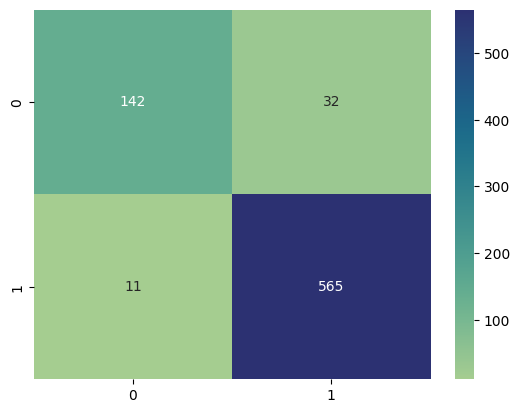

In [ ]:
cm = confusion_matrix(df_pred['label'],df_pred['pred'])
sns.heatmap(cm, annot=True, fmt = "d",cmap="crest")
print("Matriz de confusión - siebert/sentiment-roberta-large-english")
print(classification_report(df_pred['label'],df_pred['pred']))

####  Uso del modelo transformer 'LiYuan/amazon-review-sentiment-analysis'

##### Carga del modelo, tokenizador

In [ ]:
model, tokenizer, collator = get_model('LiYuan/amazon-review-sentiment-analysis')

##### Creación de un pipeline para cargar el modelo y tokenizar

In [ ]:
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model = model,
    tokenizer=tokenizer,
    device=device)

##### Evaluación de datos que el modelo predijo.

In [ ]:
task_evaluator = evaluator("sentiment-analysis")
eval_results = task_evaluator.compute(
    model_or_pipeline = sentiment_pipeline,
    input_column = 'review',
    label_mapping= {"1 star": 0, '2 stars': 0, '3 stars': 0, '4 stars': 1, '5 stars': 1},
    label_column = 'labels',
    data =  ds['test'])

In [ ]:
print(f'accuracy:{eval_results["accuracy"]}')

accuracy:0.9186666666666666


**Nota:**

El modelo 'LiYuan/amazon-review-sentiment-analysis' tuvo un 91.86% de Precisión.

El modelo 'siebert/sentiment-roberta-large-english' tuvo un 94 % de Precisión.

La diferencia podría estar en el modelo 'siebert/sentiment-roberta-large-english' esta adecuado para una salida binaria positivo y negativo y el modelo 'LiYuan/amazon-review-sentiment-analysis' esta adecuado para una salida de 5 clases.

* ### b. Utiliza ahora un ajuste de parámetros (fine-tuning) con el modelo Transformer DistilBERT, para generar un nuevo modelo y clasificación de los comentarios. Es decir, el objetivo es utilizar un modelo Transformer pre-entrenado y adaptarlo (fine-tuning) o ajustarlo a las características de tus datos de entrenamiento. Indicar desempeño (accuracy) obtenido.###

#### Carga del modelo, tokenizador

In [ ]:
model, tokenizer, collator = get_model('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifi

#### Tokenización del Corpus

In [ ]:
#Tokenizamos el dataset
tokenized_ds = ds.map(preprocess_function,batched = True)

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

#### Almacenamiento de modelo en Hugging face

In [ ]:
from huggingface_hub import notebook_login

In [ ]:
# notebook_login()

#### Entrenamiento del modelo

In [ ]:
repo_name = "finetuning-sentiment-model-amazonbaby-5000samples-MNA-NLP-EQ5"

training_args = TrainingArguments(
output_dir=repo_name,
learning_rate=2e-5,
do_eval=True,
per_device_train_batch_size=16,
per_device_eval_batch_size=16,
num_train_epochs=2,
#evaluation_strategy='steps',
weight_decay=0.01,
save_strategy="epoch",
push_to_hub=False,)
#use_mps_device=torch.backends.mps.is_available()) #Usar MPS si está disponible. Aplica para las macs con apple silicon

In [ ]:
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_ds['train'], ## data set entrenamiento.
   eval_dataset=tokenized_ds['valid'],## data set de Validación
   tokenizer=tokenizer,
   data_collator=collator,
   compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


TrainOutput(global_step=438, training_loss=0.2535603841145833, metrics={'train_runtime': 343.6965, 'train_samples_per_second': 20.367, 'train_steps_per_second': 1.274, 'total_flos': 927271790592000.0, 'train_loss': 0.2535603841145833, 'epoch': 2.0})


#### Evaluemos el modelo con datos que no vio durante el entrenamiento

In [ ]:
trainer.evaluate(tokenized_ds['test'])   # evaluemos el desempeño de este modelo...

{'eval_loss': 0.28325361013412476,
 'eval_accuracy': 0.9013333333333333,
 'eval_runtime': 13.3666,
 'eval_samples_per_second': 56.11,
 'eval_steps_per_second': 3.516,
 'epoch': 2.0}

**Nota:**

Obtenemos un 90% para este subconjunto de 5000 comentarios Amazonbaby.

In [ ]:
# trainer.push_to_hub()

##### Conversión de datos para visualización en un data frame.

In [ ]:
predictions = trainer.predict(tokenized_ds['test'])

In [ ]:
final_preds = [{
    'text': ds['test']['review'][i],
    'pred': pred,
    'label': ds['test']['labels'][i]
    } for i,pred in enumerate(predictions.predictions.argmax(-1))]

In [ ]:
df_pred_tuned = pd.DataFrame(final_preds)

In [ ]:
df_pred_tuned

,text,pred,label
0,Waste of money! My daughter would not suck the...,0,0
1,Just what we needed for our maltese puppy! We...,1,1
2,Great for tub or in pool. Not flat like other...,1,1
3,My son started chewing his clothes in Kinderga...,1,1
4,Purchased this seat for my grandson had a chan...,0,0
...,...,...,...
745,I saw this while browsing and decided to get i...,1,1
746,"We have tried many sit and stand stroller, thi...",1,1
747,my 6 1/2 month old was teething in earnest and...,1,1
748,Much sturdier and better quality wood that i e...,0,1


##### Evaluación de datos que el modelo predijo con los datos originales con una matriz de confusión

Matriz de confusión - finetuning-sentiment-model-amazonbaby-5000samples-MNA-NLP-EQ5
              precision    recall  f1-score   support

           0       0.77      0.82      0.79       174
           1       0.94      0.93      0.94       576

    accuracy                           0.90       750
   macro avg       0.86      0.87      0.86       750
weighted avg       0.90      0.90      0.90       750



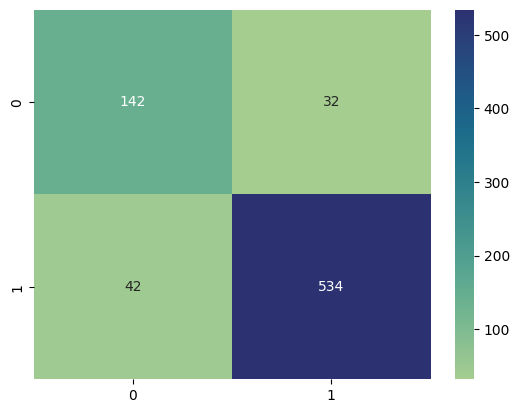

In [ ]:
cm_tuned = confusion_matrix(df_pred_tuned['label'],df_pred_tuned['pred'])
sns.heatmap(cm_tuned, annot=True, fmt = "d",cmap="crest")
print("Matriz de confusión - finetuning-sentiment-model-amazonbaby-5000samples-MNA-NLP-EQ5")
print(classification_report(df_pred_tuned['label'],df_pred_tuned['pred']))

**Nota:**

Obtenemos un 90% para este subconjunto de 5000 comentarios Amazonbaby usando el set de datos de test que nunca vio en el entrenamiento. Se confirma con la matriz de confusion y con la librería hugging face.

* ### c. Compara los resultados e incluye tus comentarios.###
### NOTA: Puedes apoyarte en el siguiente tutorial de la misma comunidad de HF: https://huggingface.co/blog/sentiment-analysis-python ###

Al comparar los modelos previamente utilizados, podemos apreciar que el que tuvo mejor rendimiento fue Siebert. Esto considerando el Accuracy de 94.26% durante la Tokenización y de 94.00% en la predicción. Consideramos que esto ocurre ya que dicho modelo tiene una salida binaria, lo cual está homologado con nuestra base y el requerimiento de la práctica. Por su parte, al aplicar el modelo LiYuan, pudimos apreciar que los resultados seguían siendo adecuados, con un 91.86% de Accuracy. Sin embargo, dada la naturaleza de dicho modelo, decidimos que podría ser una versión que no necesariamente se ajusta a nuestras necesidades. En este punto es importante resaltar que el objetivo de LiYuan es poder predecir el rating o puntaje con base en una reseña. Por último, el resultado del modelo DistilBert está muy cercano a los otros. Esto nos sorprendió bastante, ya que según las fuentes que consultamos, tiene únicamente 60% de los parámetros comparado con la versión BERT base-unicased.

### 4.- Utiliza el modelo Transformer pre-entrenado para diferentes idiomas llamado Helsinki-NLP de HF, para hacer una traducción del Inglés al Español de los 5000 comentarios. Observa algunos de los comentarios traducidos y comenta qué tan bien consideras dichas traducciones. Por el momento esun simple comentario subjetivo, aunque existen métricas y bases de datos para evaluar el desempeño de un Trasnformer.###

###NOTA: Guarda el archivo de los comentarios traducidos para facilitar su uso en las siguientes preguntas de esta actividad.###

### Existen pocos modelos pre-entrenados con corpus en Español, pero dos de los más conocidos son BETO ( https://github.com/dccuchile/beto ) y MarIA ( https://arxiv.org/abs/2107.07253 ). En particular para análisis de sentimiento se puede utilizar alguno de los modelos derivados de BETO:###

#### Creación de pipleline con el modelo Helsinki y traducción de 20 comentarios.

In [ ]:
pipe = pipeline(
    "translation",
    model="Helsinki-NLP/opus-mt-en-es",
    tokenizer= 'Helsinki-NLP/opus-mt-en-es',
    truncation = True,
    device=device,
    batch_size = 16,
    max_length = 512)

#Como demostración, se traducen 20 comentarios para que al correrlo no tarde mucho el modelo.
# Sin embargo, el trabajo de la traducción ya se hizo y se carga el archivo de los 5,000 comentarios más abajo
translations = pipe(ds_copy['train']['review'][:20])

#### Visualización de 5 comentarios traducidos.

In [ ]:
translations[:5]

[{'translation_text': 'Creo que es más caro que la farmacia que sólo cuesta 27usd.So usted tiene una buena elección si usted quiere, pero'},
 {'translation_text': 'Cuando vi esto en Amazon, lo puse en mi lista de deseos para que pudiera encontrarlo de nuevo. Sabía que sería el próximo regalo de bebé que iba a comprar. La oportunidad surgió recientemente y tan pronto como leí la invitación de la ducha, puse mi pedido. Esto parece tan cómodo. Me encanta que tenga una segunda cubierta que le permita crecer con el niño. Tantos artículos diseñados para un bebé se utilizan sólo por un tiempo tan corto, pero esto debe ser capaz de ser utilizado por mucho más tiempo. He dado esto a la madre-a-ser y ella estaba encantada de recibirlo. El niño de 7 años tuvo que probarlo, ya haciendo planes sobre cómo ella y el nuevo bebé puede compartirlo para ver la televisión! Hay un strisp en la parte inferior que lo hace mover de habitación a habitación fácil. La cremallera de la cubierta, para cambiar a la

##### Convertir a una lista  los cometarios traducidos y asignación de etiquetas

In [ ]:
translation_list = {'review': [translation['translation_text'] for translation in translations], 'labels': ds_copy['train']['labels'][:20]}
pd.DataFrame(translation_list)

,review,labels
0,Creo que es más caro que la farmacia que sólo ...,0
1,"Cuando vi esto en Amazon, lo puse en mi lista ...",1
2,Realmente nos gustan estos valances. Tienen pe...,1
3,No hay luz que emita de la luz nocturna. Lo pi...,0
4,Realmente esperaba que esto fuera un dispensad...,0
5,Mi hijo de dos años ama esta estantería!! Lo h...,1
6,Esta luz fue maravillosa durante los primeros ...,0
7,Me enviaron por correo el producto equivocado ...,0
8,El colchón es un poco delgado y no es lo sufic...,1
9,Usé estos baberos en mi hijo mayor y los amé. ...,1


##### Conversión de datos aun data set y un data frame para visualización.

In [ ]:
#llevamos los comentarios traducidos a un dataframe de pandas
ds_translated = Dataset.from_dict(translation_list)
ds_translated.to_pandas().head()

,review,labels
0,Creo que es más caro que la farmacia que sólo ...,0
1,"Cuando vi esto en Amazon, lo puse en mi lista ...",1
2,Realmente nos gustan estos valances. Tienen pe...,1
3,No hay luz que emita de la luz nocturna. Lo pi...,0
4,Realmente esperaba que esto fuera un dispensad...,0


### Guardado de los comentarios en un archivo csv.

In [ ]:
#Guardamos las traducciones en un csv. Utilizanmos amazonbaby20 como nombre del archivo para no sobrescribir el que tiene los 5,000 comentarios.
ds_translated.to_csv('./amazonbaby20-es.csv')

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

6919

#### **Nota:**

Todos los pasos anteriores se ejecutaron con los 5000 comentarios pero el tiempo de ejecución fue largo y data frame generado se guardo en un archivo csv para después usarse.


In [ ]:
#Leemos el de los 5,000 comentarios que estaremos utilizando
ds_translated = load_dataset('csv', data_files='https://github.com/rafaeljosem/NLP/raw/main/Semana%208/amazonbaby5000-es.csv')

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
ds_translated['train'].to_pandas().head()

,review,labels
0,Creo que es más caro que la farmacia que sólo ...,0
1,"Cuando vi esto en Amazon, lo puse en mi lista ...",1
2,Realmente nos gustan estos valances. Tienen pe...,1
3,No hay luz que emita de la luz nocturna. Lo pi...,0
4,Realmente esperaba que esto fuera un dispensad...,0


In [ ]:
ds_translated = split_dataset(ds_translated)

###5.- Utiliza el modelo Transformer “pysentimiento”, basado en BETO y este a su vez basado en BERT, para llevar a cabo un análisis de sentimiento (sentiment analysis) y hacer la predicción de los comentarios traducidos al español. Incluye tus comentarios del resultado obtenido.###

Para este apartado estaremos usando la librería de Pysentimiento de dos maneras:

1. Primero la usaremos sin reentrenarla ni modificando sus parámetros
2. Luego reentrenaremos el modelo con los comentarios traducidos y compararemos el accuracy obtenido en este caso vs el anterior.

#### Ejemplo 1: Pysentimiento sin reentrenar

In [ ]:
#Obtenemos el modelo
model, tokenizer, collator = get_model('pysentimiento/robertuito-base-uncased', num_labels = 2, max_length = 128)

Some weights of the model checkpoint at pysentimiento/robertuito-base-uncased were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pysentimiento/robertuito-base-uncased and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_pr

In [ ]:
#Generamos un pipeline

pipe = pipeline(
    'sentiment-analysis',
    model=model,
    tokenizer=tokenizer,
    truncation = True,
    max_length = 128,
    padding = True,
    device=get_device())

In [ ]:
#Evaluamos los resultados obtenidos
print(evaluate_results(pipe, ds_translated['test'], {"LABEL_1": 0, 'LABEL_0': 1}))

{'accuracy': 0.6013333333333334, 'total_time_in_seconds': 21.47874328800026, 'samples_per_second': 34.91824404917628, 'latency_in_seconds': 0.028638324384000345}


El modelo de pysentimiento tiene un accuracy de 60% cuando se usa sin ningún tipo de optimización.

Ejemplo 2: Pysentimiento optimizado

In [ ]:
#Cargamos el modelo nuevamente
model, tokenizer, collator = get_model('pysentimiento/robertuito-base-uncased', num_labels = 2, max_length = 128)

Some weights of the model checkpoint at pysentimiento/robertuito-base-uncased were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pysentimiento/robertuito-base-uncased and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_pr

In [ ]:
#Tokenizamos el dataset
tokenized_ds = ds_translated.map(preprocess_function,batched = True)

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

In [ ]:
#Generamos el entrenador

trainer = Trainer(
   model=model,
   args=get_training_args(),
   train_dataset=tokenized_ds['train'],
   eval_dataset=tokenized_ds['valid'],
   tokenizer=tokenizer,
   #data_collator=data_collator,
   compute_metrics=compute_metrics
)

In [ ]:
#Entrenamos el modelo
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


TrainOutput(global_step=438, training_loss=0.28009449510269513, metrics={'train_runtime': 194.8293, 'train_samples_per_second': 35.929, 'train_steps_per_second': 2.248, 'total_flos': 460444346880000.0, 'train_loss': 0.28009449510269513, 'epoch': 2.0})

In [ ]:
#Evaluamos los resusltados
trainer.evaluate(tokenized_ds['test'])

{'eval_loss': 0.2994072139263153,
 'eval_accuracy': 0.8853333333333333,
 'eval_runtime': 6.4954,
 'eval_samples_per_second': 115.466,
 'eval_steps_per_second': 7.236,
 'epoch': 2.0}

In [ ]:
#Predecimos los resultados
predictions = trainer.predict(tokenized_ds['test'])

In [ ]:
#Generamos un diccionario
final_preds = [{
    'text': ds_translated['test']['review'][i],
    'pred': pred,
    'label': ds_translated['test']['labels'][i]
    } for i,pred in enumerate(predictions.predictions.argmax(-1))]

In [ ]:
#Creamos un dataframe
df_pred = pd.DataFrame(final_preds)

#### Evaluación de datos que el modelo predijo con los datos originales con una matriz de confusión.

Matriz de confusión - pysentimiento/roberta-es-sentiment
              precision    recall  f1-score   support

           0       0.76      0.75      0.75       174
           1       0.92      0.93      0.93       576

    accuracy                           0.89       750
   macro avg       0.84      0.84      0.84       750
weighted avg       0.88      0.89      0.89       750



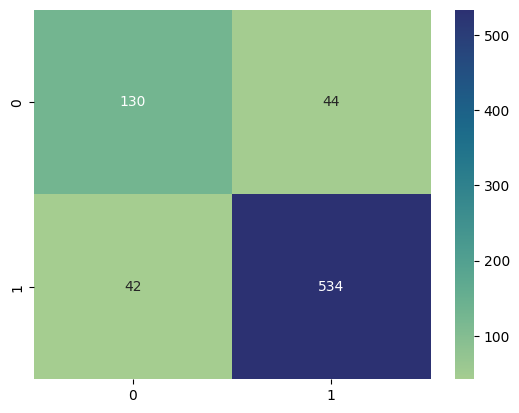

In [ ]:
cm_esp = confusion_matrix(df_pred['label'],df_pred['pred'])
sns.heatmap(cm_esp, annot=True, fmt = "d",cmap="crest")
print("Matriz de confusión - pysentimiento/roberta-es-sentiment")
print(classification_report(df_pred['label'],df_pred['pred']))

**Nota:**

El modelo 'pysentimiento/roberta-es-sentiment' obtiene un 89% de exactitud con los comentarios traducidos al español cuando este es reentrenado.

El modelo tiene un mejor desempeño cuando es entrenado con los comentarios previamente traducidos.

### 6.- Resume los resultados obtenidos en esta actividad de manera tabular e incluye tus comentarios finales.###

###NOTA: A partir de esta actividad, no dudes en experimentar con otros modelos Transformer pre-entrenados tanto para traducción al español, como para análisis de sentimiento.###

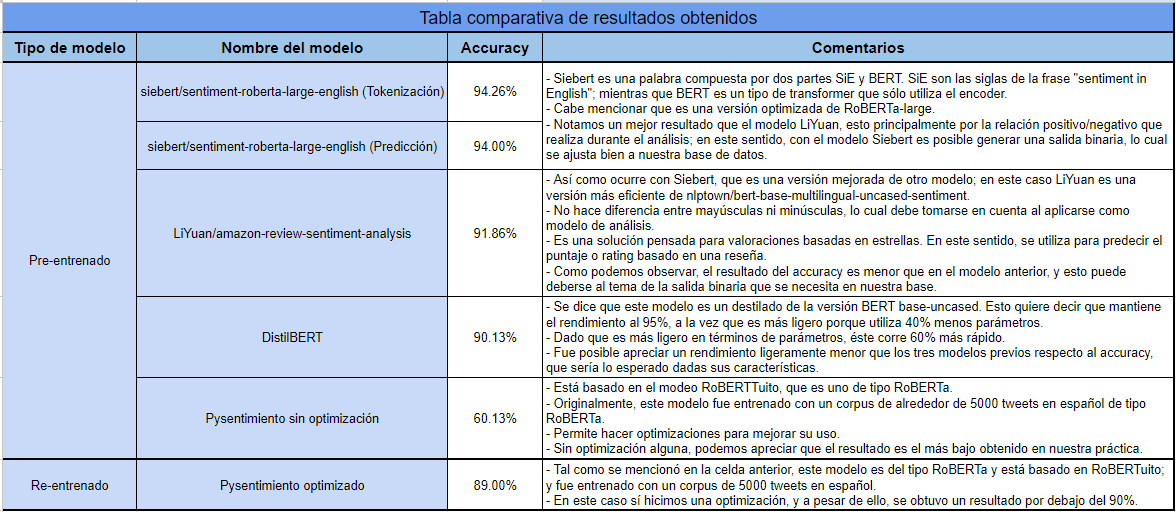

Finalmente, debemos reconocer la importancia de los modelos pre-entrenados, puesto que, de inicio, la práctica se construyó básicamente a partir de ellos, los cuales son un buen punto de inicio, puesto que aprovechan el conocimiento previamente generado por otros expertos en el gremio y permite potenciar el análisis, sin necesidad de entrenar un modelo desde cero. En otras palabras, solamente en el pre-entrenamiento, se requieren los grandes corpus o volúmenes de datos, mientras que al emplearlos ya solo será necesario realizar un nuevo ajuste de parámetros (fine-tuning), es decir, generar nuevos pesos.
Asimismo, conocer plataformas de código abierto para acceder a modelos pre-entrenados es de gran utilidad, pues brinda las herramientas al alcance de cualquiera para comenzar a trabajar con la IA, sin que se deba ser especialista. Por tanto, las personas que no tengan un conocimiento tan fundamentado podrán experimentar con los modelos, si bien, con ciertas limitantes, podrán usarse ya para desplegar distintos análisis en las bases de datos, desde visualizar cómo están distribuidos los datos, hasta como tal generar estadísticos, realizar predicciones, categorizar y entenderlos a partir del proceso. Cabe destacar que, una vez que nos hemos asegurado que los datos están limpios para su procesamiento, no es necesaria la partición convencional de los datos, donde se genera el conjunto de entrenamiento, prueba y validación, puesto que en sí el modelo ya fue entrenado con un gran conjunto de datos y lo que haríamos sería ajustar los pesos a nuestra aplicación particular, por lo que probaríamos con los nuevos parámetros y entonces, una vez ajustados, procederíamos únicamente analizar el desempeño contra el set de validación.
De acuerdo con nuestra experiencia en los análisis de las distintas soluciones reentrenadas que encontramos, podemos rescatar que si bien, estos resultan un atajo para los equipos de análisis, también es relevante que su implementación considere factores tales como:
-	Fuente de origen del algoritmo. Como bien sabemos también se debe cuidar qué librerías usamos para verificar un correcto procesamiento de los datos
-	Tipo de datos requeridos. Dado que puede ser un esquema binario o con clasificaciones ordinales, como también considerar las bases de datos especializadas o las empleadas, debido a su confiabilidad y aplicación
-	Ajuste de hiperparámetros y métricas de salida

## **Referencias:**

* Devlin, J., Chang, M. W., Lee, K., y Toutanova, K. (2019). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding. ArXiv, 1810.04805 (1-16). https://arxiv.org/abs/1810.04805

* Falcón Morales, L. E. (2023).  Maestría en Inteligencia Artificial Aplicada. ITESM

* Sudharsan Ravichandiran. (2021).Getting Started with Google BERT. O'Reilly. https://learning.oreilly.com/library/view/getting-started-with/9781838821593/

* S.A. (s.f.). pysentimiento/robertuito-sentiment-analysis, Hugging Face, https://huggingface.co/pysentimiento/robertuito-sentiment-analysis

* S.A.  (s.f.).,siebert/sentiment-roberta-large-english, Hugging Face, https://huggingface.co/siebert/sentiment-roberta-large-english

* S.A., (s.f.). LiYuan/amazon-review-sentiment-analysis, Hugging Face, https://huggingface.co/LiYuan/amazon-review-sentiment-analysis

* S.A., (s.f.). LiYuan/amazon-review-sentiment-analysis, Hugging Face, https://huggingface.co/LiYuan/amazon-review-sentiment-analysis

* S.A., (s.f.).LDistilBERT, Hugging Face, https://huggingface.co/docs/transformers/model_doc/distilbert